**Final Project: Overdamped and Markovian Langevin Equation**

Frédéric Sonak, Classical Complex Systems WS24/25

This markdown was created with the assistance of ChatGPT, focusing on grammar, spelling, and readability.

**Background**

In systems where the timescale along the system coordinate is significantly slower than all other motions in the simulation, the Langevin equation can be used to model the system. This project focuses on the motion of a one-dimensional particle, described by its position $x(t)$, in a double-well potential $U(x)$, where the potential defines the system’s landscape and naturally confines the particle to a finite region without requiring explicit boundary conditions.

The double-well potential serves as a fundamental model in statistical mechanics and thermodynamics. It is widely used in the study of bistable systems, including chemical reaction rates in transition state theory, nucleation dynamics in phase transitions, and conformational changes in protein folding. In such systems, a particle transitions between two stable states separated by an energy barrier, making it an excellent model for studying stochastic transitions.

Simulations like this are also widely used in modeling energy landscapes, such as in nucleation dynamics and protein folding studies. One-dimensional potentials provide a simple but effective way to explore these landscapes, helping to understand rare transitions and escape processes. Many computational methods rely on such potentials to study how systems move between stable states over time. This reminds me of my term paper on "Determining Biological Process Rates via Metadynamics", where a history-dependent bias is used to help explore parts of the energy landscape that classical methods struggle to reach. By gradually modifying the potential, metadynamics makes it possible to overcome energy barriers and map out transition rates more efficiently.

This project is divided into three tasks:
 1. Implement the Markovian Langevin Equation and analyze its trajectory, histogram, and transition rates for a given set of parameters. To achieve this, each position is assigned to either the left or right state, depending on its location within the potential. This classification allows for the calculation of transition probabilities between the two states, determining the likelihood of a particle moving from the right well to the left and vice versa.
2. Implement the Overdamped Langevin Equation and repeat the analysis performed in Task 1. In the high-friction limit, inertial effects become negligible, simplifying the equation of motion. The trajectory, histogram, and transition rates are computed using the overdamped equation, and the results are compared to those obtained from the Markovian Langevin simulation. This comparison provides insight into how different regimes of friction influence the system’s dynamics and transition behavior.
3. Compare the Markovian and Overdamped Langevin Equations by running simulations for different friction coefficients (\Gamma). The goal is to determine at what level of damping the two approaches yield similar results. The transition rates obtained from both simulations are compared against theoretical predictions based on Kramers’ escape rate theory. This analysis helps identify the friction regime in which the overdamped approximation becomes valid.




We begin by importing all libraries used in this code.

In [11]:

import matplotlib.pyplot as plt
import numpy as np
import time
import time

In [12]:
# This is just to count the time it took for the entire notebook to run through.
# The result is printed at the end

# Record the start time at the very beginning of the notebook
start_time = time.time()

**Task 1: Implement Markovian Langevin Equation**

To describe the particle’s dynamics, we implement the Markovian Langevin equation. The evolution of the particle’s position follows:

$
x(t + \Delta t) = x(t) + v(t) \Delta t
$

where the velocity is given by:

$
v(t + \Delta t) = v(t) - \frac{1}{m} \frac{dU (x(t))}{dx} \Delta t - \frac{1}{m} \Gamma v(t) \Delta t + \frac{1}{m} \sqrt{2k_B T \Gamma \Delta t R (t)}
$

where:
- $m$ is the particle's mass,

- $\Gamma$ is the friction coefficient,

- $k_B T$ represents the thermal energy at temperature T,

- $R(t)$ is a Gaussian random variable with zero mean and unit variance, representing stochastic thermal fluctuations.

Unlike the constant potential in the exercise sheet (Sheet 10), this simulation considers a double-well potential, given by:

$
U(x) = k_B T (0.28(0.25x^4 + 0.1x^3 - 3.24x^2) + 3.5)
$.

**Defining the Potential and Its Derivatives**

Since the force acting on the particle is given by the gradient of the potential:

$
F(x) = -\frac{dU}{dx}
$

we need to compute the deriviative of $U(x)$. These derivatives are defined explicitly in the code, as they are essential for later calculations.

While derivatives can be calculated manually or using computational tools such as SymPy, Python’s symbolic mathematics library, SymPy does not differentiate standard Python functions directly because they are interpreted numerically rather than symbolically. To illustrate symbolic differentiation in Python, an example using SymPy is provided at the end of the notebook. However, for better readability and efficiency, we explicitly define the derivatives within the code.

In [13]:
# define potential and deriviatives

# Since k_B * T is fixed at 38 in later calculations, we define:
# k_B_x_T = k_B * T to simplify the notation.

def U(x, k_B_x_T):
    return k_B_x_T * (0.28 * (0.25 * x**4 + 0.1 * x**3 - 3.24 * x**2) + 3.5)


def dU_dx(x, k_B_x_T):
    return  k_B_x_T * x * (0.28 * x**2 + 0.084 * x - 1.8144)

# needed for task 3
def ddU_ddx(x, k_B_x_T):
    return k_B_x_T * (0.84 * x**2 + 0.168 * x - 1.8144)

To better understand the system’s behavior, we plot the potential function. This visualisation helps illustrate the two stable states (wells) and the energy barrier between them.

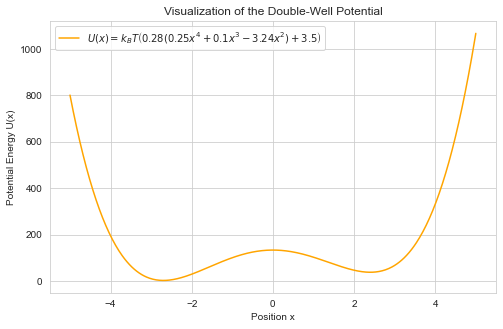

In [14]:
# Define the x-axis range for visualization
x = np.linspace(-5, 5, 500)  # Generate 500 points from x = -5 to x = 5

# Compute the potential function U(x) using the given k_B * T value (38 ps^-1)
k_B_x_T = 38
U_values = U(x, k_B_x_T)

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(x, U_values, label=r"$U(x) = k_B T \left( 0.28(0.25x^4 + 0.1x^3 - 3.24x^2) + 3.5 \right)$", color="orange")

# Add labels, title, and legend
plt.xlabel("Position x")
plt.ylabel("Potential Energy U(x)")
plt.title("Visualization of the Double-Well Potential")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

The plotted potential function reveals a double-well structure with two local minima: one at  x = -2.7  (left) and another at  x = 2.4  (right). The two wells are separated by a potential barrier located at  x = 0 , corresponding to the local maximum. Additionally, it can be observed that the left minimum is slightly lower in energy than the right minimum. This asymmetry will play a crucial role in the transition dynamics analysed later in the project.

With the potential and its derivatives defined, we can now implement the Langevin integrator to simulate the particle’s motion. The following implementation is based on a similar integrator from Sheet 10, adapted for the double-well potential used in this project.

In [15]:

def langevin_integrator(steps, dt, x0, v0, mass, gamma, k_B_x_T, verbose=False):

    # Debugging output: Print simulation parameters
    if verbose:
        print("Running Langevin integrator with the following parameters:")
        print(f'Steps: {steps}, dt: {dt}, x0: {x0}, v0: {v0}, '
              f'mass: {mass}, gamma: {gamma}, k_B_x_T: {k_B_x_T}')


    # Initialize arrays for storing positions and velocities
    positions = np.zeros((steps))
    velocities = np.zeros((steps))

    # Set initial position and velocity
    positions[0] = x0
    velocities[0] = v0

    # calculate constants outside of loop to remove redundant calculations
    # This was found to speed up the calculations by about 20 % for large loops
    const_1 = gamma * dt / mass
    const_2 = np.sqrt(2  * k_B_x_T * gamma *  dt) / mass

    # Main integration loop
    loop_range = range(steps - 1)
    for i in loop_range:
        # Generate Gaussian noise (mean = 0, variance = 1)
        R = np.random.normal(0, 1)

        # Current velocity and position
        v = velocities[i]
        x = positions[i]

        # Update velocity using Langevin equation
        v_next = v + (-dU_dx(x, k_B_x_T) / mass) * dt - const_1 * v + const_2 * R
        # Update position
        x_next = x + v_next * dt

        # Store the updated values
        velocities[i + 1] = v_next
        positions[i + 1] = x_next

        # Debugging output: Print intermediate values at every 10% of steps
        # This check was included because, during the implementation,
        # unstable simulations were observed where forces and positions increased uncontrollably, leading to numerical divergence.
        if verbose:
            if i % (steps // 10) == 0:  # Print 10 times throughout simulation
                print(f"Step {i}: x = {x_next:.5f}, "
                      f"v = {v_next:.5f}, force = {-dU_dx(x, k_B_x_T):.2f} noise = {R:.5f}")


    return positions, velocities

The implemented integrator can now be used to simulate the system using the parameters provided in the task sheet. During debugging, the number of simulation steps can be reduced by a factor of 100 to 1000 to accelerate computations and facilitate troubleshooting.

In [ ]:
# Run simulation using parameters from the task sheet

# Define simulation parameters
gamma = 100        # Friction coefficient (no unit)
k_B_x_T = 38       # Boltzmann constant times temperature (ps^¹)
dt = 0.001         # Time step size (ps)
steps = 50 * 10**6 # Number of time steps (can be reduced for debugging)
mass = 1           # Particle mass (ps)
x0 = 0             # Initial position (no unit)
v0 = 0             # Initial velocity (ps^¹)

# Run simulation
positions_markovian, velocities_markovian = langevin_integrator(steps, dt, x0, v0, mass, gamma, k_B_x_T, verbose=True)

Running Langevin integrator with the following parameters:
Steps: 50000000, dt: 0.001, x0: 0, v0: 0, mass: 1, gamma: 100, k_B_x_T: 38
Step 0: x = -0.00396, v = -3.96063, force = 0.00 noise = -1.43667
Step 5000000: x = 2.65940, v = 3.03009, force = -38.81 noise = 0.36962
Step 10000000: x = -3.30583, v = -0.42284, force = 121.48 noise = 1.09776


A quick inspection of the debugging output confirms that the simulation remains numerically stable for the chosen parameters, with no signs of divergence or unphysical values. To further analyze the results, we visualize the trajectory by plotting the particle’s position over time.

In [ ]:
# Plot the trajectory of the particle over time
plt.figure(figsize=(10, 5))

plt.plot(np.arange(steps), positions_markovian, label="Position")

# Labels and Title
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.title("Langevin Dynamics Simulation")
plt.legend()
plt.grid(True)
plt.show()

The trajectory plot clearly shows that the particle predominantly explores two stable states, corresponding to the local minima of the potential at approximately  x = -2.7  (left well) and  x = 2.4  (right well). Throughout the simulation, multiple transitions between these two states can be observed, reflecting the stochastic nature of the Langevin dynamics.

To further quantify the system’s behavior, we analyze the distribution of positions by computing a histogram of the particle’s trajectory. This empirical distribution can then be compared to the theoretical Boltzmann distribution, which describes the expected probability distribution of states in thermal equilibrium.

In [ ]:
# Plot histogram of the trajectory
plt.figure(figsize=(8, 5))
plt.hist(positions_markovian, bins=100, density=True, color="blue", alpha=0.6, edgecolor="black")

# Mark core state boundaries
plt.axvline(-1, color="red", linestyle="--", label="Left Core Boundary (-1)")
plt.axvline(1, color="green", linestyle="--", label="Right Core Boundary (1)")

# Define the Boltzmann distribution P(x) \propto exp(-U(x) / k_B T)
def boltzmann_distribution(x, k_B_x_T):
    P_x = np.exp(-U(x, k_B_x_T) / k_B_x_T)
    return P_x / np.trapz(P_x, x)  # Normalise by dividing through the integration of the Boltzmann distribution

# Compute and plot theoretical Boltzmann distribution
P_x = boltzmann_distribution(x, k_B_x_T)
plt.plot(x, P_x, label="Boltzmann Distribution", color="orange")

# Labels, Title, and Legend
plt.xlabel("Position x")
plt.ylabel("Probability Density")
plt.title("Histogram of the Trajectory")
plt.legend()
plt.grid(True)
plt.show()

he histogram provides a clear visualization of the system’s behavior. The two distinct peaks correspond to the local minima of the double-well potential, confirming that the particle spends most of its time in these stable states. Additionally, the probability density smoothly approaches zero for extreme values of  x , indicating that the integrator is numerically stable and does not produce unphysical position values.

Furthermore, we observe that the empirical distribution closely follows the theoretical Boltzmann distribution, confirming that the simulated trajectory correctly samples the equilibrium distribution expected for a system in thermal equilibrium. This agreement suggests that the Langevin dynamics simulation accurately captures the stochastic behavior dictated by the potential landscape.

**Assigning Core States (Left/Right)**
Next, we assign each particle position to one of two core states: left or right.
To ensure consistency, the initial state at $( x = 0 )$ is assigned to "left" by default.

The assignment rules are as follows:
- If the particle's position satisfies $( x < -1 )$, it is classified as left (0).
- If the particle's position satisfies $( x > 1 )$, it is classified as right (1).
- For intermediate positions between the two boundaries $(-1 \leq x \leq 1)$, the last visited state is retained.

This hysteresis-based assignment prevents rapid fluctuations at the potential barrier and ensures a physically meaningful classification of transitions between the two states.


In [ ]:
# defining the assign state function
def assign_core_states(positions):

    # Initialize the state array (0 = left, 1 = right)
    states = np.zeros(len(positions), dtype=int)

    # Assume the simulation starts in the left state (x(0) = 0)
    current_state = 0

    # Iterate through the trajectory and assign states
    for i in range(len(positions)):
        x = positions[i]
        if x < -1:
            current_state = 0  # Left
        elif x > 1:
            current_state = 1  # Right
        # If -1 <= x <= 1, keep the last assigned state

        states[i] = current_state  # Store the state

    return states

In [ ]:
# running the assign state function for the Markovian simulation
states_markovian = assign_core_states(positions_markovian)

To verify the correctness of the state assignment, a quick statistical check is performed. This involves counting the occurrences of left (0) and right (1) states to ensure they sum up to the total number of steps. If the sum is correct, we can confirm that no double assignment or misclassification occurred in the state labeling.

In [ ]:
def quick_statistics_check(states, verbose=True):
    # Count occurrences of left (0) and right (1) states
    left_count = np.sum(states == 0)
    right_count = np.sum(states == 1)

    # Total simulations
    total_simulations = len(states)

    # Check if the sum is correct
    sum_check = left_count + right_count == total_simulations

    # Print results
    if verbose:
        print(f"Left states (0): {left_count} = {left_count/total_simulations*100}%")
        print(f"Right states (1): {right_count} = {right_count/total_simulations*100}%")
        print(f"Total states: {total_simulations}")
        print(f"Check if both add up correctly: {'Yes' if sum_check else 'No'}")

    return left_count, right_count



In [ ]:
# running the statistics check for the Markovian Simulation
count_left_right_markovian, count_right_left_markovian  = quick_statistics_check(states_markovian)

At first glance, the results appear consistent. Since the left minimum of the potential is lower in energy than the right minimum, the particle is expected to spend more time in the left state. The statistical check confirms this behavior, with a higher occurrence of the left state. Additionally, the total number of assigned states matches the total number of simulation steps, indicating that no double counting or misclassification has occurred.

**Counting Transitions and Computing Transition Rates**

Next, we count the state transitions between the two wells:

- $( N_{\text{left} \rightarrow \text{right}} )$: The number of times the particle transitions from the left well to the right well.
- $( N_{\text{right} \rightarrow \text{left}} )$: The number of times the particle transitions from the right well to the left well.

The transition rate $( k_{\text{left} \rightarrow \text{right}} )$ is defined as:

$
k_{\text{left} \rightarrow \text{right}} = \frac{N_{\text{left} \rightarrow \text{right}}}{N_{\text{left}} \cdot \Delta t}
$

Similarly, the reverse transition rate $( k_{\text{right} \rightarrow \text{left}} )$ is given by:

$
k_{\text{right} \rightarrow \text{left}} = \frac{N_{\text{right} \rightarrow \text{left}}}{N_{\text{right}} \cdot \Delta t}
$

These rates describe how frequently the particle escapes from one potential well to the other within a given time step $( \Delta t )$, providing key insights into the system's stochastic dynamics.

In [ ]:
def compute_transition_rates(states, left_count, right_count, verbose=True):
    # Count transitions from left (0) to right (1) and vice versa
    N_left_to_right = np.sum((states[:-1] == 0) & (states[1:] == 1))
    N_right_to_left = np.sum((states[:-1] == 1) & (states[1:] == 0))

    # Compute transition rates
    k_left_to_right = N_left_to_right / (left_count * dt)
    k_right_to_left = N_right_to_left / (right_count * dt)

    # Print results
    if verbose:
        print(f"Transition rate k(left -> right): {k_left_to_right:.5f} per ps")
        print(f"Transition rate k(right -> left): {k_right_to_left:.5f} per ps")

    return k_left_to_right, k_right_to_left


In [ ]:
# computing transition rates for the markovian simulation
k_left_to_right_langevin,k_right_to_left_langevin = compute_transition_rates(states_markovian, count_left_right_markovian, count_right_left_markovian, verbose=True)

To conclude Task 1, we visualize a segment of the trajectory  x(t)  that captures a transition between the two states. This provides a clear representation of how the particle moves between the left and right potential wells over time.

In [ ]:
# TODO before printing get a good region for this plot

# Define a trajectory interval that captures a visible transition between states
start_index = 200000
end_index = 400000

# Generate corresponding time array
time_array = np.arange(start_index, end_index) * dt

# Plot the trajectory for the selected interval
plt.figure(figsize=(10, 5))
plt.plot(time_array, positions_markovian[start_index:end_index], label="x(t)", color="blue")

# Mark core state boundaries
plt.axhline(-1, color="red", linestyle="--", label="Left Core Boundary (-1)")
plt.axhline(1, color="green", linestyle="--", label="Right Core Boundary (1)")


plt.xlabel("Time (ps)")
plt.ylabel("Position x(t)")
plt.title("Exemplary Trajectory of a Particle")
plt.legend()
plt.grid(True)
plt.show()

**Task 2: Implement overdamped Langevin equation**

In the high-friction limit, the system experiences strong damping, and the acceleration term becomes negligible:

$
\frac{dv}{dt} \approx 0
$

This simplifies the Langevin equation for position updates to:

$
x(t + \Delta t) = x(t) - \frac{1}{m} \frac{1}{\Gamma} \frac{dU(x(t))}{dx} \Delta t
+ \frac{1}{m} \sqrt{\frac{2k_B T \Delta t}{\Gamma}} R(t)
$

In this regime, velocity no longer plays a role because the motion is entirely governed by a balance between the deterministic force from the potential and random thermal fluctuations. Any acceleration is instantaneously damped by friction, meaning that the system reaches a quasi-equilibrium where the particle continuously adjusts to the local energy landscape.

To study the impact of this approximation, we rerun the simulation under the same conditions as in Task 1 and compare the results. First, we implement the overdamped Langevin integrator.

In [ ]:
#TODO Do i need to remove mass? It doesnt make a numerical differnce as the variable is one, but in theory the overdamped langevin equation inertia is neglegible so mass should vanish, right?


def overdamped_langevin_integrator(steps, dt, x0, mass, gamma, k_B_x_T, verbose=False):
    if verbose:
        print(f' Running overdamped langevin integration with the following parameters:')
        print(f' steps: {steps}')
        print(f' dt: {dt}')
        print(f' x0: {x0}')
        print(f' mass: {mass}')
        print(f' gamma: {gamma}')
        print(f' k_B_x_T: {k_B_x_T}')

    # Initialize position array
    positions = np.zeros(steps)

    # Set initial position
    positions[0] = x0

    # Precompute noise scaling factor
    sqrt_2kBT_dt_gamma = np.sqrt(2 * k_B_x_T * dt / gamma)

    # Integration loop
    loop_range = range(steps - 1)
    for i in loop_range:
        # Generate Gaussian noise (mean 0, variance 1)
        noise = np.random.normal(0, 1)

        # current position
        x = positions[i]

        # Compute force (minus is included here!)
        force = -dU_dx(positions[i], k_B_x_T)

        # Overdamped Langevin update
        x_next = x + (force / (gamma* mass)) * dt + (1/mass) * sqrt_2kBT_dt_gamma * noise

        # Store the updated value
        positions[i+1] = x_next

        # Debugging to check stability
        if verbose:
            if i % (steps // 10) == 0:  # Print 10 times throughout simulation
                print(f"Step {i}: x = {positions[i + 1]:.5f}, force = {force:.2f}, noise = {noise:.5f}")

    return positions


In [ ]:
# Use the same simulation parameters as for the Markovian Langevin simulation

# Run simulation
positions_overdamped = overdamped_langevin_integrator(steps, dt, x0, mass, gamma, k_B_x_T, verbose=True)


The simulation remains stable, with no signs of numerical instability or diverging values. As in the Markovian Langevin simulation, we now visualize the results to analyze the system’s behavior.

In [ ]:
# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(np.arange(steps), positions_overdamped, label="Position", color="green")
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.title("Overdamped Langevin Dynamics Simulation")
plt.legend()
plt.grid(True)
plt.show()

As observed in Task 1, the system explores the two states corresponding to the potential’s minima. Once again, the majority of the time is spent in the left minimum, which is at a lower energy state. In the following histogram, the distribution of the Overdamped Langevin dynamics is compared to the Markovian Langevin dynamics as well as the theoretical Boltzmann distribution.

In [ ]:
# Plot histogram of the trajectory
plt.figure(figsize=(8, 5))

# Histogram of Overdamped Langevin
plt.hist(positions_overdamped, bins=100, density=True, label="Overdamped Langevin",
         color="green", alpha=0.3, edgecolor="black")

# Histogram of Markovian Langevin
plt.hist(positions_markovian, bins=100, density=True, label="Markovian Langevin",
         color="blue", alpha=0.6, edgecolor="black")

# Plot Boltzmann Distribution for reference
plt.plot(x, P_x, label="Boltzmann Distribution", color="orange", linewidth=2)

# Mark core state boundaries
plt.axvline(-1, color="red", linestyle="--", label="Left Core Boundary (-1)")
plt.axvline(1, color="green", linestyle="--", label="Right Core Boundary (1)")

plt.xlabel("Position x")
plt.ylabel("Probability Density")
plt.title("Histogram of the Trajectory")
plt.legend()
plt.grid(True)
plt.show()

Here both simulations show the same expected theoretical result. Another way to perhaps more closely compare the two distributuins is by moving from a histagram to kernel density estimate. This can be done with seaborne.

Both simulations (Overdamped Langevin and Markovian Langevin) yield the same expected theoretical result as shown in the histogram. However, to facilitate a more detailed comparison of the two distributions, we can transition from a histogram to a Kernel Density Estimate (KDE). The KDE provides a smoothed estimate of the probability density function, which can offer a clearer view of the underlying distribution.

The KDE can be easily plotted using Seaborn. By smoothing the distributions, we can perhaps more accurately compare the two Langevin dynamics models against the theoretical Boltzmann distribution.

In [ ]:
# KDE PLOT to better see how similar the two simulations are. Carefull this takes quite long.

import seaborn as sns

plt.figure(figsize=(10, 6))

sns.kdeplot(positions_overdamped, label="Overdamped Langevin", color="green", linewidth=2)
sns.kdeplot(positions_markovian, label="Markovian Langevin", color="blue", linewidth=2)

plt.xlabel("Position x")
plt.ylabel("Density")
plt.title("KDE Plot: Overdamped vs Markovian")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

From the KDE comparison,  it is evident that both the Overdamped Langevin and Markovian Langevin simulations yield very similar results. The distributions closely align with the theoretical Boltzmann distribution, indicating that both simulations are in strong agreement with the expected theoretical behavior. This suggests that the Langevin dynamics in both cases are consistent with the assumptions underlying the Boltzmann distribution, confirming the validity of the simulation models.

**State Assignment and Statistical Analysis**

Similar to the Markovian Langevin simulation, states are now assigned to the system, and a brief statistical analysis is conducted. Following this, the transition rates between the identified states are calculated.

In [ ]:
states_overdamped = assign_core_states(positions_overdamped)

left_count_overdamped, right_count_overdamped = quick_statistics_check(states_overdamped, verbose=True)

In [ ]:
# Transition Rates
k_left_to_right_overdamped,k_right_to_left_overdamped = compute_transition_rates(states_overdamped, left_count_overdamped, right_count_overdamped, verbose=True)

The transition rates between the Markovian Langevin and Overdamped Langevin simulations can now be compared.

The bar plot below compares the transition rates for each direction under both simulations. The blue bars represent the rates from the Langevin simulation, while the orange bars represent the rates from the Overdamped Langevin simulation.

In [ ]:

# store variables from above as lists for simple visualisation
types = ["Left to Right", "Right to Left"]
langevin_rates = [k_left_to_right_langevin, k_right_to_left_langevin]
overdamped_rates = [k_left_to_right_overdamped, k_right_to_left_overdamped]

# Plot comparison
x = np.arange(len(types))  # Bar positions
width = 0.3  # Width of the bars

plt.figure(figsize=(8, 5))
plt.bar(x - width / 2, langevin_rates, width=width, label="Markovian", color="blue")
plt.bar(x + width / 2, overdamped_rates, width=width, label="Overdamped", color="green")


plt.xticks(x, types)
plt.ylabel("Transition Rate (per ps)")
plt.title("Comparison of Transition Rates: Markovian vs Overdamped")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

It can be observed that the Right to Left transition rate is substantially higher than the transition from Left to Right in both simulations. This behavior is consistent with the asymmetry in the double-well potential, where it is energetically easier for a particle to leave the right state than it is for it to escape from the left state.

For both transitions, the Overdamped Langevin simulation shows slightly higher transition rates compared to the Markovian Langevin simulation. This could be attributed to the nature of the overdamped approximation, where forces are felt instantaneously due to the high friction (or damping), resulting in faster equilibration between states. In the Markovian Langevin simulation, on the other hand, both friction and inertia are considered, which means the particle’s velocity plays a role in determining its transition dynamics. The inclusion of inertia may slow down transitions.


And finally for task 2 an exemplary trajectory of a particle is presented and compared with an exemplary trajectory for the markovian simulation.

In [ ]:
# Define example trajectory interval
start_index = 2000
end_index = 4000

# Generate time array
time_array = np.arange(start_index, end_index) * dt

# Plot the trajectory
plt.figure(figsize=(10, 5))

# Overdamped
plt.plot(time_array, positions_overdamped[start_index:end_index], label="x(t) overdamped", color="green")

# Markovian
plt.plot(time_array, positions_markovian[start_index:end_index], label="x(t) markovian", color="blue")

# Mark core state boundaries
plt.axhline(-1, color="red", linestyle="--", label="Left Core Boundary (-1)")
plt.axhline(1, color="green", linestyle="--", label="Right Core Boundary (1)")

plt.xlabel("Time (ps)")
plt.ylabel("Position x(t)")
plt.title("Exemplary Trajectory of a Particle (Overdamped Langevin)")
plt.legend()
plt.grid(True)
plt.show()

his illustration clearly shows the rapid, erratic fluctuations of the overdamped system, where the lack of significant inertia means the particle does not “speed up” or “slow down” but changes position instantaneously. In contrast, the Markovian trajectory presents a smoother, more realistic motion, where inertia allows for gradual oscillations and more natural dynamics.

**Task 3: Comparison of Langevin Equations**

In the last step both Langevin equations will be run for different friction coefficients $\Gamma$ ranging from 75 down to 10.

The calculated transition rates $k_{i \rightarrow j}$ will be compared with the theoretical formula

$
k_{i \to j}(\Gamma) \approx \frac{\omega_i \omega_{\text{max}}}{2 \pi \Gamma} e^{-\frac{U(x_{\text{max}}) - U(x_i)}{k_B T}}
$

where $\omega_i^2 = \frac{d^2 U (x_i)}{dx^2}$ and $\omega_\mathrm{max}^2 = - \frac{d^2 U (x_\mathrm{max}) - U (x_i)}{dx^2}$.


In [ ]:
# Run Langevin for range of friction coefficients

# Define range of gamma values to test
gamma_values = np.array([ 100, 75, 55, 40, 30, 15, 10])  # Different damping values

# Store transition rates
k_left_to_right_markovian = []
k_right_to_left_markovian = []
k_left_to_right_overdamped = []
k_right_to_left_overdamped = []

# loop through gamma values
for gamma in gamma_values:
    print(f"\n**** Running simulations for gamma = {gamma}")

    # Run Task 1 (Markovian Langevin)
    print(f'Running Markovian Langevin Simulation')

    positions_markovian, velocities_markovian = langevin_integrator(steps, dt, x0, v0, mass, gamma, k_B_x_T, verbose=False)
    states_markovian = assign_core_states(positions_markovian)
    left_count_m, right_count_m = quick_statistics_check(states_markovian, verbose=False)
    k_m_left, k_m_right = compute_transition_rates(states_markovian, left_count_m, right_count_m, verbose=False)

    print(f'transition rates: {k_m_left, k_m_right}')

    k_left_to_right_markovian.append(k_m_left)
    k_right_to_left_markovian.append(k_m_right)


    # Run Task 2 (Overdamped Langevin)
    print(f'Running Overdamped Langevin Simulation')
    positions_overdamped = overdamped_langevin_integrator(steps, dt, x0, mass, gamma, k_B_x_T, verbose=False)
    states_overdamped = assign_core_states(positions_overdamped)
    left_count_o, right_count_o = quick_statistics_check(states_overdamped, verbose=False)
    k_o_left, k_o_right = compute_transition_rates(states_overdamped, left_count_o, right_count_o, verbose=False)

    print(f'transition rates: {k_o_left, k_o_right}')

    k_left_to_right_overdamped.append(k_o_left)
    k_right_to_left_overdamped.append(k_o_right)

The results from the two simulations must be compared to the theoretical values. These values are calculated using the formulas outlined earlier. For this comparison, we will calculate the theoretical transition rates for each friction coefficient \Gamma.

There are two states: left and right, each associated with the position of its potential minimum. The left state is assigned x = -2.7 (calculated manually, as shown above), and the right state is assigned x = 2.4. The following code calculates the theoretical transition rates based on the given formulas.

In [ ]:

# Implementing the functions from the sheet
def theoretical_transition_rate(gamma, omega_i, omega_max, U_max, U_i, k_B_x_T):
    return (omega_i * omega_max) / (2 * np.pi * gamma) * np.exp(-(U_max - U_i) / k_B_x_T)

def omega_i(x_i, k_B_x_T):
    omega_i_squared = ddU_ddx(x_i, k_B_x_T)
    return np.sqrt(omega_i_squared)

def omega_max(x_max, k_B_x_T):
    omega_max_squared = -ddU_ddx(x_max, k_B_x_T)
    return np.sqrt(omega_max_squared)

# Define parameters (calculated manually)
x_left = -2.7
x_right = 2.4
x_max = 0  # Barrier location

# Compute potential values
U_max = U(x_max, k_B_x_T)
U_left = U(x_left, k_B_x_T)
U_right = U(x_right, k_B_x_T)


# Compute transition rates
k_left_to_right_theoretical = []
k_right_to_left_theoretical = []

# loop through gamma values
for gamma in gamma_values:
    k_lr = theoretical_transition_rate(gamma, omega_i(x_left, k_B_x_T), omega_max(x_max, k_B_x_T), U_max, U_left, k_B_x_T)
    k_rl = theoretical_transition_rate(gamma, omega_i(x_right, k_B_x_T), omega_max(x_max, k_B_x_T), U_max, U_right, k_B_x_T)

    k_left_to_right_theoretical.append(k_lr)
    k_right_to_left_theoretical.append(k_rl)

    print(f"Gamma = {gamma}: k_left_to_right = {k_lr:.5f}, k_right_to_left = {k_rl:.5f}")



Finally, all transition rates are compared.

In [ ]:
# plot transition right to left
plt.figure(figsize=(10, 6))

plt.plot(gamma_values, k_right_to_left_theoretical, 'v--', label="theoretical", color="orange")
plt.plot(gamma_values, k_right_to_left_markovian, '^--', label="Markovian", color="blue")
plt.plot(gamma_values, k_right_to_left_overdamped,'^--', label="Overdamped", color="green")

plt.xlabel(r'Friction coefficient $\Gamma$ for the Transition Right to Left')
plt.ylabel(r'Transition rate $k$ (per ps)')
plt.title('Comparison of Transition Rates')
plt.legend()
# plt.xscale('log')  # Log scale for better visualization
# plt.yscale('log')  # Log scale for better comparison

plt.grid()
plt.show()


# Plot transition left to right
plt.figure(figsize=(10, 6))

plt.plot(gamma_values, k_left_to_right_theoretical, 'v--', label="theoretical", color="orange")
plt.plot(gamma_values, k_left_to_right_markovian, '^--', label="Markovian", color="blue")
plt.plot(gamma_values, k_left_to_right_overdamped,'^--', label="Overdamped", color="green")

plt.xlabel(r'Friction coefficient $\Gamma$ for the Transition Left to Right')
plt.ylabel(r'Transition rate $k$ (per ps)')
plt.title('Comparison of Transition Rates')
plt.legend()
# plt.xscale('log')  # Log scale for better visualization
# plt.yscale('log')  # Log scale for better comparison

plt.grid()
plt.show()

In both cases (left to right and right to left) the Markovian Simulation diverges further away from the theoretical calculations for small friction coefficients. here, the overdamped Langevin appears to give better results.

For large friction coefficients the right to left transition indicates a trend where the markovian simulation might be closer to the theoretical calculations. The right to left transition does not show a clear trend.

To further investigate this one could explore even larger friction coefficients although, due to the arbitrary units I am not sure how realistic simulations would then be.




In theory one would expect the overdamped simulation to work good for systems with large friction constants. In these systems inertia has little effect on the dynamics. Examples would be motions of particles in viscous liquids.

On the other hand the markovian Langevin simulations might be more suitable for simulations with more moderate Friction coefficients.

**Appendix**

**Example of how to use SYMPY in Python**

In [ ]:
# example of how to use sumpy to determine minimas, maximas, differentiation etc.

import sympy as sp

# Define the variable
x = sp.Symbol('x', real=True)

# Define the function
f = 38 * (0.28 * (0.25 * x**4 + 0.1 * x**3 - 3.24 * x**2) + 3.5)

# Compute the first derivative
f_prime = sp.diff(f, x)

# Solve for critical points (where f' = 0)
critical_points = sp.solve(f_prime, x)

# Compute the second derivative
f_double_prime = sp.diff(f_prime, x)

# Determine which critical points correspond to local maxima
local_maxima = [point.evalf() for point in critical_points if f_double_prime.subs(x, point) < 0]

# Display the local maxima
print(f" local maximum at x = {local_maxima}")

In [ ]:
# Record the end time at the very end of the notebook
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Total execution time for the entire notebook: {elapsed_time:.2f} seconds")